# Object detection with detectron2

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import vision # no import * because ¯\_(ツ)_/¯
import matplotlib.pyplot as plt

from torch import nn
import torch

import numpy as np

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from fastai.callbacks import hooks as faihooks

In [9]:
def show_bgr(im):
    im = im[:, :, ::-1]
    fig = plt.figure(figsize=(16, 16))
    plt.imshow(im)

In [10]:
!wget https://s3.amazonaws.com/cms.ipressroom.com/233/files/20156/55a1aadb5e8eef5d9f9c313d_Open+Bridle+Champion+Suzon+Schaal/Open+Bridle+Champion+Suzon+Schaal_6c89d7a9-1fea-4cfc-bf7b-5af81dcaaa5d-prv.jpg -O input.jpg

--2020-03-30 12:18:59--  https://s3.amazonaws.com/cms.ipressroom.com/233/files/20156/55a1aadb5e8eef5d9f9c313d_Open+Bridle+Champion+Suzon+Schaal/Open+Bridle+Champion+Suzon+Schaal_6c89d7a9-1fea-4cfc-bf7b-5af81dcaaa5d-prv.jpg
Auflösen des Hostnamens s3.amazonaws.com (s3.amazonaws.com) … 52.216.97.85
Verbindungsaufbau zu s3.amazonaws.com (s3.amazonaws.com)|52.216.97.85|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 116172 (113K) [image/jpeg]
Wird in »input.jpg« gespeichert.

input.jpg           100%[===================>] 113,45K   459KB/s    in 0,2s    

2020-03-30 12:19:00 (459 KB/s) - »input.jpg« gespeichert [116172/116172]



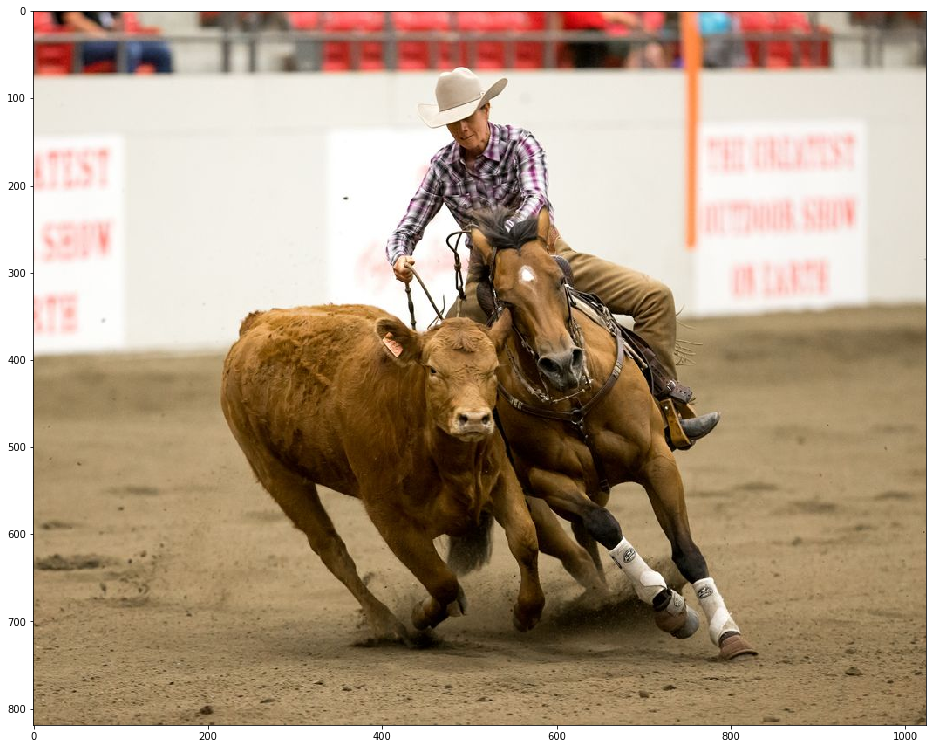

In [11]:
im = cv2.imread("input.jpg")
show_bgr(im)

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

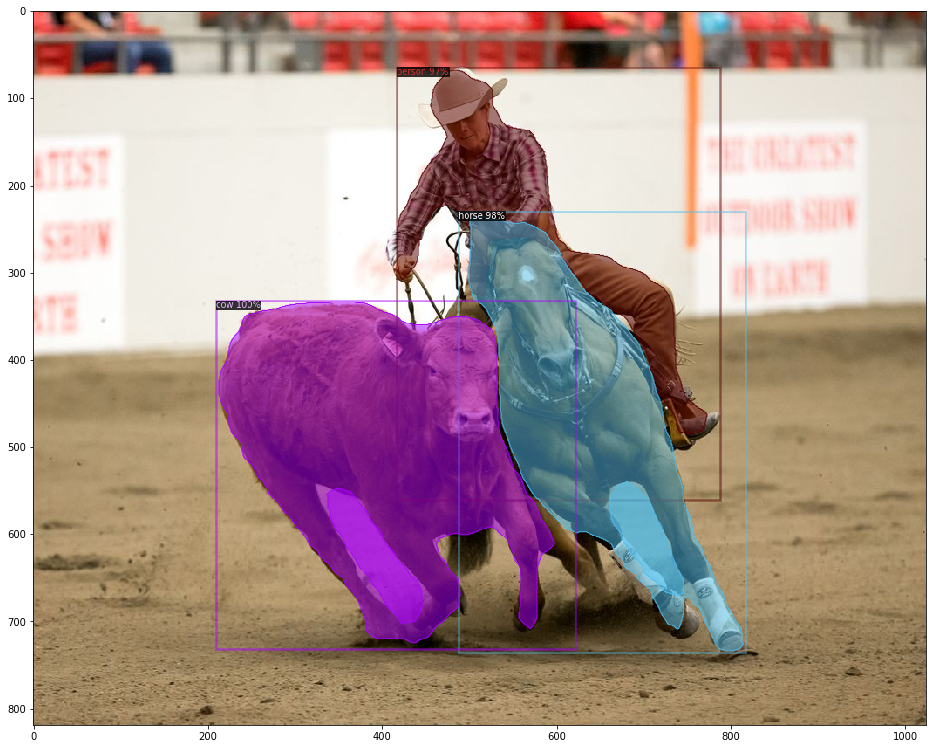

In [56]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.)
v = v.draw_instance_predictions(outputs["instances"].to("cpu") )
show_bgr(v.get_image()[:, :, ::-1])

Only plotting the region proposals needs some more steps. First, we need to preprocess the image manually. This image is then fed through the FPN backbone to retrieve the extracted features. We can then compute the region proposals based on the image input and the features.

In [6]:
output_height, output_width = im.shape[:2]
im_transformed = predictor.transform_gen.get_transform(im).apply_image(im)
im_transformed = torch.as_tensor(im_transformed.astype("float32").transpose(2, 0 ,1))
im_transformed = predictor.model.normalizer(im_transformed.cuda())
images = detectron2.structures.ImageList.from_tensors([im_transformed], predictor.model.backbone.size_divisibility)
im_transformed.shape
image_size = list(im_transformed.shape[1:])

In [7]:
predictor.model.eval()
features = predictor.model.backbone(images.tensor)
proposals, _ = predictor.model.proposal_generator(images, features, None)
proposals = proposals[0]

The image which is fed through the network has a different shape than our original image: compute the scales for each bounding box.

In [205]:
scale_x, scale_y = (output_width / image_size[1], output_height / image_size[0])

Get boxes and logits from the results

In [213]:
fields = proposals.get_fields()
boxes = fields["proposal_boxes"].to("cpu")
logits = fields["objectness_logits"].cpu()
boxes.scale(scale_x, scale_y)
boxes.clip(image_size)

Choose only the top 50 boxes.

In [228]:
inds = torch.topk(logits, k=50, dim=0).indices

Overlay region proposals on the original image.

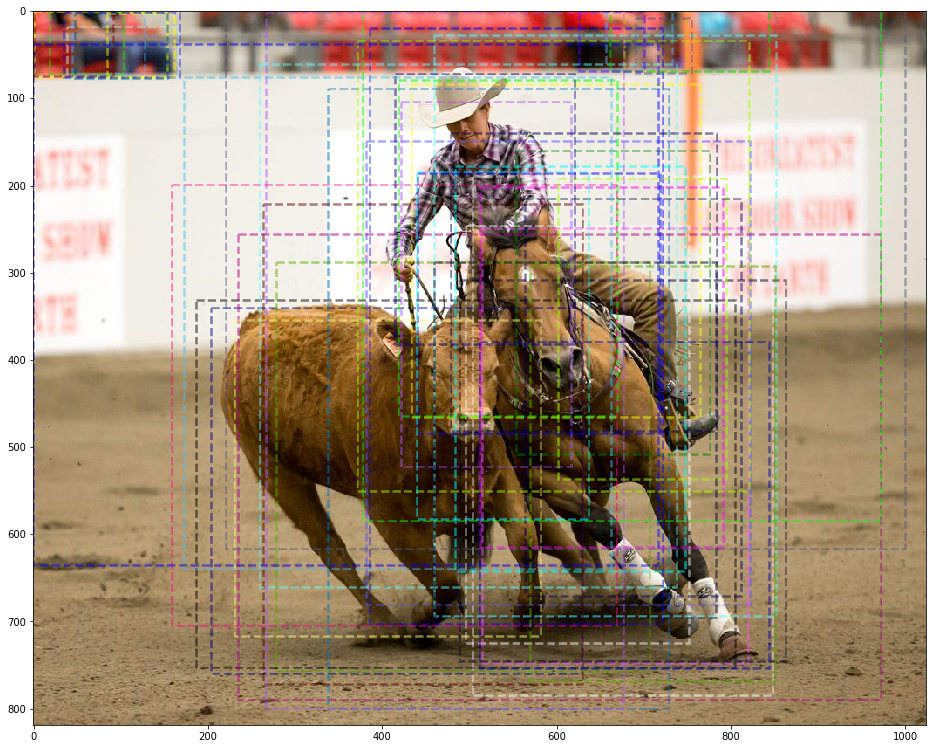

In [230]:
colors = [detectron2.utils.colormap.random_color(rgb=True, maximum=1) for _ in range(len(boxes))]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.)
for i, (b, c) in enumerate(zip(boxes, colors)):
    if i in inds:
        v.draw_box(b, edge_color=c,line_style="--")
show_bgr(v.output.get_image()[:, :, ::-1])